In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import random
import csv
import os

1. preprocess data

In [2]:
train_data = pd.read_csv("dataset/train.csv", encoding='big5')
test_data = pd.read_csv("dataset/test.csv", encoding='big5')
sample_submission = pd.read_csv("dataset/sampleSubmission.csv", encoding='big5')

* train

In [3]:
train_data = train_data.iloc[:, 3:]
train_data.shape

(4320, 24)

In [4]:
train_data.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,14,14,14,13,12,12,12,12,15,17,...,22,22,21,19,17,16,15,15,15,15
1,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,...,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8
2,0.51,0.41,0.39,0.37,0.35,0.3,0.37,0.47,0.78,0.74,...,0.37,0.37,0.47,0.69,0.56,0.45,0.38,0.35,0.36,0.32
3,0.2,0.15,0.13,0.12,0.11,0.06,0.1,0.13,0.26,0.23,...,0.1,0.13,0.14,0.23,0.18,0.12,0.1,0.09,0.1,0.08
4,0.9,0.6,0.5,1.7,1.8,1.5,1.9,2.2,6.6,7.9,...,2.5,2.2,2.5,2.3,2.1,1.9,1.5,1.6,1.8,1.5


In [5]:
train_data.replace("NR", 0 , inplace=True)

In [6]:
# month : 12, pollution_source : 18, days : 20, hours each day : 24
train_each_month = np.zeros((12, 18, 24 * 20), dtype=np.float64)
for i in range(train_each_month.shape[0]):
    for j in range(20):
        train_each_month[i, :, j * 24 : j * 24 + 24] = train_data.iloc[i + j * 18:i + 18 + j * 18, :]

In [7]:
train_each_month[0, 0, :48]

array([14., 14., 14., 13., 12., 12., 12., 12., 15., 17., 20., 22., 22.,
       22., 22., 22., 21., 19., 17., 16., 15., 15., 15., 15., 16., 15.,
       15., 14., 14., 15., 16., 16., 17., 20., 22., 23., 24., 24., 24.,
       24., 23., 21., 20., 19., 18., 18., 18., 18.])

* test

In [8]:
test_data = test_data.iloc[:, 2:]
test_data.shape

(4320, 9)

In [9]:
test_data.head()

,2,3,4,5,6,7,8,9,10
0,21,21,20,20,19,19,19,18,17
1,1.7,1.7,1.7,1.7,1.7,1.7,1.7,1.7,1.8
2,0.39,0.36,0.36,0.4,0.53,0.55,0.34,0.31,0.23
3,0.16,0.24,0.22,0.27,0.27,0.26,0.27,0.29,0.1
4,1.3,1.3,1.3,1.3,1.4,1.6,1.2,1.1,0.9


In [10]:
test_data.replace("NR", 0 , inplace=True)

2. prepare training data(train_x | train_y) and test data(test_x)

* train

In [11]:
train_rows = 471 * 12
train_x = np.zeros((train_rows, 18 * 9), dtype=np.float64)
train_y = np.zeros((train_rows, 1), dtype=np.float64)

In [12]:
for i in range(train_each_month.shape[0]):
    for j in range(471):
        train_x[i * 471 + j] = train_each_month[i, :, j : j + 9].flatten()
        train_y[i * 471 + j] = train_each_month[i, 9, j + 9]

In [13]:
print("train_x[2, : 10] :", train_x[2, : 10])
print("train_y[2:5] :", train_y[2:5])

train_x[2, : 10] : [14.  13.  12.  12.  12.  12.  15.  17.  20.   1.8]
train_y[2:5] : [[44.]
 [33.]
 [37.]]


In [14]:
train_bias = np.ones((train_x.shape[0], 1))
train_x = np.concatenate((train_bias, train_x), axis=1)

* test

In [15]:
test_rows = int(test_data.shape[0] / 18)
test_x = np.zeros((test_rows, 18 * 9), dtype=np.float64)
test_y = np.zeros((test_rows, 1), dtype=np.float64)

In [16]:
for i in range(test_x.shape[0]):
    test_x[i] = test_data.iloc[i * 18 : i * 18 + 18, :].values.flatten()

In [17]:
print("test_x[0, : 10] :", test_x[0, : 10])

test_x[0, : 10] : [21.  21.  20.  20.  19.  19.  19.  18.  17.   1.7]


In [18]:
test_bias = np.ones((test_x.shape[0], 1))
test_x = np.concatenate((test_bias, test_x), axis=1)

3. define train functions

In [19]:
def GD(train_x, train_y, weight, lr, iteration, lambdaL2):
    list_loss = []
    for i in range(iteration):
        predict = np.dot(train_x, weight)
        loss_bref = predict - train_y
        
        loss = np.mean(loss_bref ** 2)
        list_loss.append(loss)
        
        # f(x) = (a*x + b)^2
        # f(x)' = 2(a*x + b) * a
        grad = np.dot(train_x.T, loss_bref) / train_x.shape[0] + lambdaL2 * weight
        weight -= lr * grad
    
    return weight, list_loss

In [20]:
def ada_GD(train_x, train_y, weight, lr, iteration, lambdaL2):
    s_grad = np.zeros((train_x.shape[1], 1), dtype=np.float64)
    list_loss = []
    for i in range(iteration):
        predict = np.dot(train_x, weight)
        loss_bref = predict - train_y
        
        loss = np.mean(loss_bref ** 2)
        list_loss.append(loss)
        
        grad = np.dot(train_x.T, loss_bref) / train_x.shape[0] + lambdaL2 * weight
        # (np.random.randn((2)) + np.random.randn((2))).shape = (2,)
        s_grad += grad ** 2
        ada = np.sqrt(s_grad + 1e-8)
        weight -= lr * grad / ada
    return weight, list_loss

In [21]:
def SGD(train_x, train_y, weight, lr, iteration, lambdaL2, batch_size):
    list_loss = []
    for i in range(iteration):
        predict = np.dot(train_x, weight)
        loss_bref = predict - train_y
        
        loss = np.mean(loss_bref ** 2)
        list_loss.append(loss)
        
        rand = np.random.randint(0, train_x.shape[0], size=batch_size)
        grad = np.dot(train_x[rand].T, loss_bref[rand]) / train_x.shape[0] + lambdaL2 * weight
        weight -= lr * grad
    return weight, list_loss

4. train data

In [22]:
## hyperparameter

lr = 0.001
iteration = 20000
lambdaL2 = 0
batch_size = 64

## hyperparameter

In [23]:
weight = np.zeros((train_x.shape[1], 1))

# 梯度下降loss较大，超过np.float64存储范围，暂时不进行运算
# weight_gd, list_loss_gd = GD(train_x, train_y, weight, lr, iteration, lambdaL2)
weight_ada_gd, list_loss_ada_gd = ada_GD(train_x, train_y, weight, lr, iteration, lambdaL2)
weight_sgd, list_loss_sgd = SGD(train_x, train_y, weight, lr, iteration, lambdaL2, batch_size)

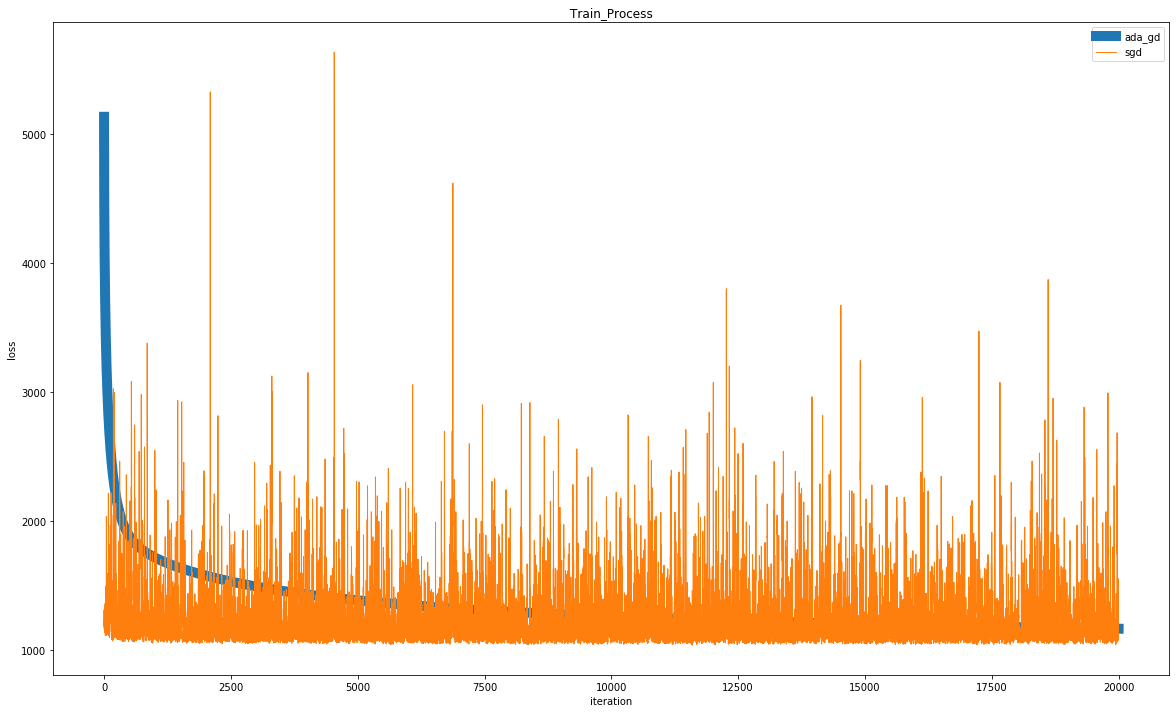

In [24]:
plt.figure(figsize=(20, 12))
plt.title("Train_Process")
plt.xlabel("iteration")
plt.ylabel("loss")
# plt.plot(list_loss_gd, label="gd")
plt.plot(list_loss_ada_gd, label="ada_gd", linewidth=10)
plt.plot(list_loss_sgd, label="sgd", linewidth=1)
plt.legend()
plt.show()

In [25]:
# y_gd = np.dot(test_x, weight_gd)
y_ada_gd = np.dot(test_x, weight_ada_gd)
y_sgd = np.dot(test_x, weight_sgd)

5. save data to file

In [26]:
sample_submission.pop("value")
sample_submission.insert(1, "value_gd", y_ada_gd)
sample_submission.insert(1, "value_sgd", y_sgd)
sample_submission.tail()

,id,value_sgd,value_gd
235,id_235,57.398249,57.398249
236,id_236,71.087574,71.087574
237,id_237,58.913058,58.913058
238,id_238,16.356835,16.356835
239,id_239,18.610697,18.610697


In [27]:
sample_submission.to_csv("./dataset/sampleSubmission.csv")

[reference link](https://github.com/maplezzz/NTU_ML2017_Hung-yi-Lee_HW/tree/master/HW1)